# Transforms

> Custom PyTorch batch transforms

In [ ]:
#| default_exp transforms

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from pathlib import Path

import numpy as np
import fastcore.all as fc

import torch
from torchvision import transforms as T


In [ ]:
#|eval: false
import matplotlib.pyplot as plt
from lssm.loading import load_ossl
from lssm.preprocessing import ToAbsorbance, ContinuumRemoval
from lssm.dataloaders import SpectralDataset, get_dls
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [ ]:
#| export
class GADFTfm(): 
    """
    Transform batch of spectra S (B, 1, len(S)) into their Grammian Difference Matrix Field (GADF) of shape (B, 1, H, W)
    
    Notes:
    https://arxiv.org/pdf/1506.00327.pdf
    """
    def __init__(self, neg=True):
        self.neg = neg
        
    def rescale(self, x):
        m = torch.min(x, dim=-1, keepdim=True).values
        M = torch.max(x, dim=-1, keepdim=True).values
        return ((x - M) + (x - m)) / (M - m) if self.neg else (x - m) / (M - m)

    def __call__(self, 
                 b # Batch of spectra S: (B, 1, len(S))
                 ): 
        x, y, *metadata = b
        X, I = self.rescale(x), torch.ones_like(x)
        K = torch.sqrt(I - torch.square(X))
        x = (torch.matmul(torch.transpose(K, 1, 2), X) - 
             torch.matmul(torch.transpose(X, 1, 2), K)).unsqueeze_(1)
        return x, y, *metadata

Example:

In [ ]:
#|eval: false

# Load data
analytes = 'k.ext_usda.a725_cmolc.kg'
data = load_ossl(analytes, spectra_type='visnir')
X, y, X_names, smp_idx, ds_name, ds_label = data

# Transform
X = Pipeline([('to_abs', ToAbsorbance()), 
              ('cr', ContinuumRemoval(X_names))]).fit_transform(X)

# Train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2,
                                                      stratify=ds_name, 
                                                      random_state=41)

# Get PyTorch datasets
train_ds, valid_ds = [SpectralDataset(X, y, ) 
                      for X, y, in [(X_train, y_train), (X_valid, y_valid)]]

# Then PyTorch dataloaders
dls = get_dls(train_ds, valid_ds, bs=32)

first_batch = next(iter(dls.train))

Reading & selecting data ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44489/44489 [00:15<00:00, 2854.63it/s]


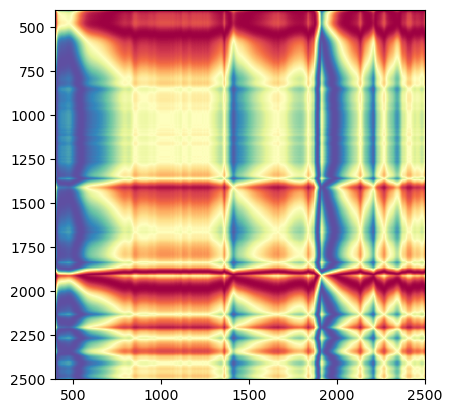

In [ ]:
#|eval: false
plt.imshow(GADFTfm()(first_batch)[0][0].squeeze().cpu(),
           cmap='Spectral', 
           origin='upper', extent=[X_names[0], X_names[-1], X_names[-1], X_names[0]]);

In [ ]:
#| export
def _resizeTfm(b, size=224):
    "Resize image"
    x, y, *metadata  = b
    return T.Resize(size)(x), y, *metadata

torch.Size([32, 1, 224, 224])


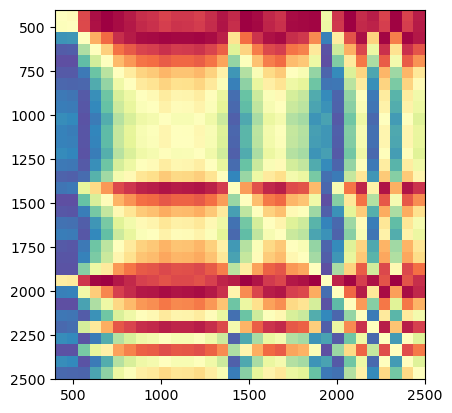

In [ ]:
#|eval: false
print(_resizeTfm(GADFTfm()(first_batch))[0].shape)
plt.imshow(_resizeTfm(GADFTfm()(first_batch), size=32)[0][0].squeeze().cpu(),
           cmap='Spectral', 
           origin='upper', extent=[X_names[0], X_names[-1], X_names[-1], X_names[0]]);

In [ ]:
#| export
class StatsTfm(): 
    """
    Set pre-trained statistics.
    """
    def __init__(self, 
                 cfgs
                 ):
        self.mean = np.array(cfgs['mean']).mean()
        self.std = np.array(cfgs['std']).mean()

    def __call__(self, b): 
        x, y, *metadata = b
        means = torch.mean(x, (2, 3), keepdim=True)
        stds = torch.std(x, (2, 3), keepdim=True)
        x = (((x - means) / stds) * self.std) + self.mean
        return x, y, *metadata

In [ ]:
#| export
class SNVTfm(): 
    "Apply SNV to input or to both input and output when used with a Variational Auto-Encoder."
    def __init__(self, 
                 is_VAE:bool=False # If VAE apply SNV on both input and output.
                 ):
        self.is_VAE = is_VAE

    def _apply_snv(self, data):
        mean = torch.mean(data, axis=-1, keepdim=True)
        std = torch.std(data, axis=-1, keepdim=True)
        return (data - mean) / std
    
    def __call__(self, b): 
        if fc.isinstance_str(b, 'tuple'):
            x, y = b
            if self.is_VAE:
                b = torch.concat(b)
                b = self._apply_snv(b)
                bs = len(x)
                return b[:bs], b[bs:]
            else:
                x = self._apply_snv(x)
                return x, y
        else:
            return self._apply_snv(b)

For instance, when X (input) is a 1D spectrum and the output is a single soil property:

In [ ]:
batch = torch.randn(32, 1, 1500), torch.randn(32, 1)
batch_transformed = SNVTfm(is_VAE=False)(batch)

fc.test_eq(batch_transformed[0].shape, [32, 1, 1500])
fc.test_eq(batch_transformed[1].shape, [32, 1])

In [ ]:
batch = torch.randn(32, 1, 1500), torch.randn(32, 1, 1500)
batch_transformed = SNVTfm(is_VAE=True)(batch)

fc.test_eq(batch_transformed[0].shape, [32, 1, 1500])
fc.test_eq(batch_transformed[1].shape, [32, 1, 1500])

In [ ]:
import nbdev; nbdev.nbdev_export()